# IMDB 데이터 세트 - LSTM 모델
IMDB 데이터 세트를 장-단기 메모리 순환 신경망으로 훈련 시킵니다.

문장으로 이루어진 IMDB 데이터를 받아와 문장이 긍정적인 평가라면 1을, 부정적인 평가라면 0을 출력하는 모델을 설계하고 훈련합니다.

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

max_features = 20000  # 하이퍼 파라미터, 사용할 최대 특징 수
text_max_words = 200  # 하이퍼 파라미터, 사용할 최대 단어 수

## IMDB 데이터 세트 다운로드 및 가공
IMDB 데이터 세트를 다운로드 받은 뒤 훈련, 테스트, 검증 세트로 나눕니다.

새로운 버전의 numpy 와의 호환성 이슈를 해결하는 코드를 삽입 하였습니다.

* 훈련 세트는 20000를 사용합니다.
* 20000 index 이상의 데이터는 검증 세트로 사용합니다.
* 크기를 일정하게 하기 위해서 패딩을 추가합니다.

In [0]:
import numpy as np

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
np.load = np_load_old

x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

## 장-단기 메모리 순환 신경망 구성
장-단기 신경망 메모리와 임베딩 레이어에 기반한 신경망을 구성합니다.
* 첫번째 계층은 임베딩 레이어로, 순차화된 문장을 정규화 합니다.
* 정규화된 텐서를 LSTM 레이어로 전달합니다. LSTM 레이어는 128개의 셀로 구성합니다.
* 마지막 계층은 이진분류를 위해 sigmoid 활성화 함수를 사용한 1개의 뉴런으로 구성합니다.

In [0]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

## 모델 정보 출력
* model.summary() 메소드를 이용하여 생성된 모델의 정보를 출력 합니다.
* Input, Output의 형태와 훈련 가능한 파라미터 개수를 출력 합니다.
* 훈련 가능한 파라미터 개수로 모델의 크기와 필요 자원을 예측해 볼 수 있습니다.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 훈련
* 이진 Corss Entropy 오류를 Adam Optimizer 를 이용하여 최소화 함을 정의합니다.
* 전체 데이터를 총 25번, 한 Backward pass 당 64개의 데이터 세트를 이용하여 훈련 함을 정의합니다.
* 컴파일 메소드를 이용하여 TensorFlow 그래프를 정의하여 훈련을 진행 합니다.

*Google Colab Cloud GPU를 이용하여 가속 하였습니다.*

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 82s 4ms/step - loss: 0.4333 - acc: 0.7976 - val_loss: 0.3077 - val_acc: 0.8724
Epoch 2/25
20000/20000 [==============================] - 81s 4ms/step - loss: 0.2339 - acc: 0.9108 - val_loss: 0.3407 - val_acc: 0.8766
Epoch 3/25
20000/20000 [==============================] - 81s 4ms/step - loss: 0.1331 - acc: 0.9519 - val_loss: 0.3493 - val_acc: 0.8594
Epoch 4/25
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0793 - acc: 0.9728 - val_loss: 0.5551 - val_acc: 0.8640
Epoch 5/25
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0702 - acc: 0.9758 - val_loss: 0.4627 - val_acc: 0.8578
Epoch 6/25
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0565 - acc: 0.9808 - val_loss: 0.5135 - val_acc: 0.8528
Epoch 7/25
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0332 - acc: 0.9897 - val_loss: 0.5314 - val_acc:

## 시각화
matplotlib를 이용하여 훈련 경과를 출력합니다.

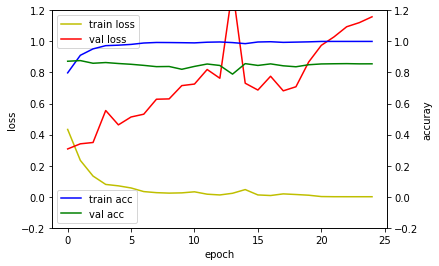

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 훈련 결과를 평가합니다.
손실과 신뢰도를 출력합니다.

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 20s 785us/step
## evaluation loss and_metrics ##
[1.2145164151382446, 0.8519200000190735]
